# Correct viral barcodes to reduce replication, PCR, and sequencing errors
This Python Jupyter notebook uses `UMI_tools` directional adjacency method to correct viral barcodes that are likely derived from errors in the replication or sequencing library preparation process.

## Notes about UMI_tools
* Using directional adjacency method. This has [been demonstrated on simulated data](https://cgatoxford.wordpress.com/2015/08/14/unique-molecular-identifiers-the-problem-the-solution-and-the-proof/) to produce a more accurate estimate of true UMI number than other heuristics.
* Sequence must be input as byte. See definition here: https://stackoverflow.com/questions/6269765/what-does-the-b-character-do-in-front-of-a-string-literal
* The corrected barcode is returned as the first barcode in the group list. See umi_tools API documentation: https://umi-tools.readthedocs.io/en/latest/API.html

Import Python modules:

In [1]:
import gzip

from IPython.display import display

from dms_variants.constants import CBPALETTE 

import pandas as pd

import plotnine as p9

from umi_tools import UMIClusterer

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [3]:
viral_bc_in_progeny_freq_csv = snakemake.input.viral_bc_in_progeny_freq_csv
viral_bc_in_progeny_corrected = snakemake.output.viral_bc_in_progeny_corrected_csv
plot = snakemake.output.plot
expt = snakemake.wildcards.expt

Import barcode frequency data

In [22]:
viral_bc_df = pd.read_csv(gzip.open(viral_bc_in_progeny_freq_csv))
display(viral_bc_df)

,source,tag,gene,barcode,mean_freq
0,second_infection,syn,fluHA,AAAAAAAGTAAATCTT,5.255458e-05
1,second_infection,syn,fluHA,AAAAAAATCTTAATAA,2.031765e-06
2,second_infection,syn,fluHA,AAAAAAATCTTAATGA,8.673284e-05
3,second_infection,syn,fluHA,AAAAAACCCAATTATT,1.061100e-06
4,second_infection,syn,fluHA,AAAAAACCCGATTATT,3.408782e-05
...,...,...,...,...,...
130646,supernatant,wt,fluNA,TTTTGTTAGCGTCCTG,3.067874e-04
130647,supernatant,wt,fluNA,TTTTTTAGAAAACGTA,8.987181e-07
130648,supernatant,wt,fluNA,TTTTTTAGAAAACGTC,1.680603e-04
130649,supernatant,wt,fluNA,TTTTTTCACTGCCATT,8.987181e-07


Cluster barcodes within each sample

In [5]:
clusterer = UMIClusterer(cluster_method="directional")

lookup_list = []

for (source, tag, gene), df in (viral_bc_df
                                .groupby(['source',
                                          'tag',
                                          'gene'])):
    n_unique_bc = df['barcode'].nunique()
    print(f"There are {n_unique_bc} unique barcodes "
          f"in the raw data for {source} {tag} {gene}")

    # Convert dataframe to dictionary. Dict requried input for umi_tools.
    viral_bc_dict = (df[['barcode', 'mean_freq']]
                     .set_index('barcode')
                     .to_dict(orient='dict'))
    viral_bc_dict = viral_bc_dict['mean_freq']

    # Convert barcode strings to byte. Byte required dtype for umi_tools.
    byte_dict = {}
    for key, value in viral_bc_dict.items():
        byte_dict[key.encode("utf-8")] = float(value)

    # Cluster barcodes
    bc_groups = clusterer(byte_dict, threshold=1)
    groups_df = pd.DataFrame(bc_groups)
    groups_df = (groups_df
                 .stack()
                 .str
                 .decode('utf-8')
                 .unstack())  # Convert bytes back to string
    groups_df = groups_df.rename(columns={0: 'corrected_bc'})
    groups_df = groups_df.set_index('corrected_bc', drop=False)
    n_corrected_bc = groups_df['corrected_bc'].nunique()
    print(f"{n_unique_bc - n_corrected_bc} barcodes were corrected.")
    print(f"There are {n_corrected_bc} corrected barcodes "
          f"for {source} {tag} {gene}\n")

    # Generate lookup table for this sample
    temp_lookup_df = (groups_df.melt(ignore_index=False,
                                     value_name='original_bc')
                      ['original_bc']
                      .dropna()
                      .reset_index())
    temp_lookup_df['source'] = source
    temp_lookup_df['tag'] = tag
    temp_lookup_df['gene'] = gene
    lookup_list.append(temp_lookup_df)

lookup_df = pd.concat(lookup_list)
display(lookup_df.describe())

There are 21467 unique barcodes in the raw data for second_infection syn fluHA
5276 barcodes were corrected.
There are 16191 corrected barcodes for second_infection syn fluHA

There are 22686 unique barcodes in the raw data for second_infection syn fluNA
3440 barcodes were corrected.
There are 19246 corrected barcodes for second_infection syn fluNA

There are 25980 unique barcodes in the raw data for second_infection wt fluHA
6063 barcodes were corrected.
There are 19917 corrected barcodes for second_infection wt fluHA

There are 20583 unique barcodes in the raw data for second_infection wt fluNA
3885 barcodes were corrected.
There are 16698 corrected barcodes for second_infection wt fluNA

There are 11147 unique barcodes in the raw data for supernatant syn fluHA
3609 barcodes were corrected.
There are 7538 corrected barcodes for supernatant syn fluHA

There are 8884 unique barcodes in the raw data for supernatant syn fluNA
3404 barcodes were corrected.
There are 5480 corrected barcode

,corrected_bc,original_bc,source,tag,gene
count,130651,130651,130651,130651,130651
unique,71020,102870,2,2,2
top,TGTTATATTTGTATTG,ACTGTTCTAACAAACA,second_infection,wt,fluHA
freq,108,6,90716,66467,71450


Merge corrected barcode data with barcode frequency data. Aggregate frequency on corrected barcodes.

In [23]:
viral_bc_df = pd.merge(viral_bc_df,
                       lookup_df,
                       left_on=['source', 'tag', 'gene', 'barcode'],
                       right_on=['source', 'tag', 'gene', 'original_bc'])
viral_bc_df = viral_bc_df.drop('barcode', axis=1)

viral_bc_df = pd.merge(viral_bc_df,
                       (viral_bc_df
                        .groupby(['source',
                                  'tag',
                                  'gene',
                                  'corrected_bc'])
                        .sum()
                        .reset_index()),
                       on=['source', 'tag', 'gene', 'corrected_bc'],
                       suffixes=['_original_bc', '_corrected_bc'])

viral_bc_df['diff'] = (viral_bc_df['mean_freq_corrected_bc']
                       - viral_bc_df['mean_freq_original_bc'])
viral_bc_df['diff_ratio'] = (viral_bc_df['diff']
                             / viral_bc_df['mean_freq_original_bc'])
viral_bc_df['corrected'] = (viral_bc_df['corrected_bc']
                            != viral_bc_df['original_bc'])
display(viral_bc_df)

,source,tag,gene,mean_freq_original_bc,corrected_bc,original_bc,mean_freq_corrected_bc,diff,diff_ratio,corrected
0,second_infection,syn,fluHA,0.000053,AAAAAAAGTAAATCTT,AAAAAAAGTAAATCTT,0.000053,0.000000,0.000000,False
1,second_infection,syn,fluHA,0.000002,AAAAAAATCTTAATGA,AAAAAAATCTTAATAA,0.000089,0.000087,42.688424,True
2,second_infection,syn,fluHA,0.000087,AAAAAAATCTTAATGA,AAAAAAATCTTAATGA,0.000089,0.000002,0.023426,False
3,second_infection,syn,fluHA,0.000001,AAAAAACCCGATTATT,AAAAAACCCAATTATT,0.000035,0.000034,32.124979,True
4,second_infection,syn,fluHA,0.000034,AAAAAACCCGATTATT,AAAAAACCCGATTATT,0.000035,0.000001,0.031128,False
...,...,...,...,...,...,...,...,...,...,...
130646,supernatant,wt,fluNA,0.000183,TTTTGTCATGATAGCC,TTTTGTCATGATAGCC,0.000185,0.000001,0.006410,False
130647,supernatant,wt,fluNA,0.000001,TTTTGTCATGATAGCC,TTTTGTCATGATAGCT,0.000185,0.000183,156.000000,True
130648,supernatant,wt,fluNA,0.000001,TTTTGTTAGCGTCCTG,TTTTGTTAGCGTCATG,0.000308,0.000307,261.000000,True
130649,supernatant,wt,fluNA,0.000307,TTTTGTTAGCGTCCTG,TTTTGTTAGCGTCCTG,0.000308,0.000001,0.003831,False


Plot fraction of reads that underwent correction:

In [7]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='corrected',
                                     y='mean_freq_original_bc',
                                     fill='corrected')) +
       p9.geom_bar(stat='identity') +
       p9.ggtitle('Barcode correction rates') +
       p9.ylab('frac reads corrected') +
       p9.facet_grid('source~tag+gene') +
       p9.scale_x_discrete(limits=(viral_bc_df['corrected']
                                   .unique()
                                   .tolist())) +  # Order categorical values
       p9.theme(figure_size=(1.5*((viral_bc_df['gene'].nunique() *
                                   viral_bc_df['tag'].nunique())),
                             1.6*viral_bc_df['source'].nunique()),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

# save plot
print(f"Saving plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

# show plot
fig.draw()

NameError: name 'plot' is not defined

In [8]:
for (source, tag, gene), df in (viral_bc_df
                                .groupby(['source',
                                          'tag',
                                          'gene'])):
    frac_corrected_df = (df.groupby(['corrected'])
                         .sum()
                         .reset_index())
    frac_corrected = (frac_corrected_df
                      .query("corrected == True")
                      ["mean_freq_original_bc"])

    print(f'For ({source}, {tag}, {gene}) sample, '
          f'{float(frac_corrected) * 100:.2f}'
          f'% of reads were corrected.')

For (second_infection, syn, fluHA) sample, 0.70% of reads were corrected.
For (second_infection, syn, fluNA) sample, 0.51% of reads were corrected.
For (second_infection, wt, fluHA) sample, 0.62% of reads were corrected.
For (second_infection, wt, fluNA) sample, 0.72% of reads were corrected.
For (supernatant, syn, fluHA) sample, 0.88% of reads were corrected.
For (supernatant, syn, fluNA) sample, 0.77% of reads were corrected.
For (supernatant, wt, fluHA) sample, 1.19% of reads were corrected.
For (supernatant, wt, fluNA) sample, 0.98% of reads were corrected.


Plot effect of correction for each barcode:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


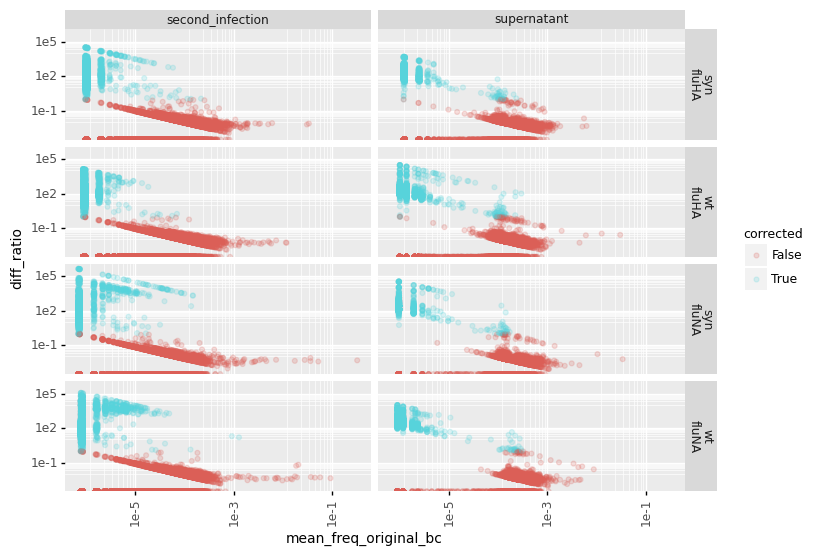

In [9]:
fig = (p9.ggplot(viral_bc_df, p9.aes(x='mean_freq_original_bc',
                                     y='diff_ratio',
                                     color='corrected')) +
       p9.geom_point(alpha=0.2) +
       p9.facet_grid('gene+tag~source') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(4 * viral_bc_df['source'].nunique(),
                             1.5 * ((viral_bc_df['gene'].nunique()
                                     * viral_bc_df['tag'].nunique()
                                     ))),
                axis_text_x=p9.element_text(angle=90),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))

fig.draw()

Export CSV of corrected barcode frequencies:

In [26]:
viral_bc_df = (viral_bc_df[['source',
                           'tag',
                           'gene',
                           'corrected_bc',
                           'mean_freq_corrected_bc']]
               .drop_duplicates()
               .rename(columns={'mean_freq_corrected_bc':
                                'freq'}))

               
viral_bc_df.to_csv(viral_bc_in_progeny_corrected,
                     columns=['source',
                              'tag',
                              'gene',
                              'corrected_bc',
                              'freq'],
                     index=False)

,source,tag,gene,corrected_bc,freq
0,second_infection,syn,fluHA,AAAAAAAGTAAATCTT,0.000053
1,second_infection,syn,fluHA,AAAAAAATCTTAATGA,0.000089
3,second_infection,syn,fluHA,AAAAAACCCGATTATT,0.000035
5,second_infection,syn,fluHA,AAAAAACGAATGGATT,0.000253
8,second_infection,syn,fluHA,AAAAAAGGGGTGTATG,0.000005
...,...,...,...,...,...
130640,supernatant,wt,fluNA,TTTTGATGGTAAGTAC,0.000223
130642,supernatant,wt,fluNA,TTTTGCTTCGAGATAG,0.001143
130646,supernatant,wt,fluNA,TTTTGTCATGATAGCC,0.000185
130648,supernatant,wt,fluNA,TTTTGTTAGCGTCCTG,0.000308
